In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
# %matplotlib widget
%matplotlib inline

## FDA Example - when function y is known

### Define function to choose between forward or central

In [ ]:
from typing import Literal, get_args

diff_TYPES = Literal['forward_diff','central_diff']

def finite_diff(h, xmin, xmax, show_plot=True, type_diff: diff_TYPES='central_diff'):
    
    # Specify permitted values for type_diff
    options = get_args(diff_TYPES)
    assert type_diff in options, f"'{type_diff}' is not in {options}"

    # define grid
    x = np.arange(xmin, xmax, h)
    # print(f'x: {len(x)}') # for debugging

    y = np.cos(x)

    if type_diff == 'central_diff':
        # compute vector of central differences
        calculated_diff = np.array([(y[i+1] - y[i-1]) / (2*h) for i in range(len(x)) if i > 0 and i < len(x)-1])
        # print(f'calculated: {len(calculated_diff)}') # for debugging
        # compute corresponding grid - since two points needed to create 1 point on new graph, so new plot has 1 less point
        x_diff = x[1:-1:] 
        # print(f'xdiff: {len(x_diff)}') # for debugging
        # compute exact solution - to check the accuracy of numerical approximation
        exact_solution = -np.sin(x_diff)
        # print(f'exact: {len(exact_solution)}') # for debugging
    
    elif type_diff == 'forward_diff':
        # compute vector of central differences
        calculated_diff = np.diff(y)/h
        # print(f'calculated: {len(calculated_diff)}') # for debugging
        # compute corresponding grid - since two points needed to create 1 point on new graph, so new plot has 1 less point
        x_diff = x[:-1:]
        # print(f'xdiff: {len(x_diff)}') # for debugging
        # compute exact solution - to check the accuracy of numerical approximation
        exact_solution = -np.sin(x_diff)
        # print(f'exact: {len(exact_solution)}') # for debugging

    else:
        pass

    
    # Plot solution - central difference
    if show_plot:
        plt.figure(figsize = (12, 8))
        plt.plot(x_diff, calculated_diff, '--', \
            label = 'Finite difference approximation')
        plt.plot(x_diff, exact_solution, \
            label = 'Exact solution')
        plt.legend()
        plt.show()

    # Compute max error between 
    # numerical derivative and exact solution
    max_error = max(abs(exact_solution - calculated_diff))

    return max_error


In [ ]:
finite_diff(0.1,0,2*np.pi,False,type_diff='forward_diff')

### Error plot

In [ ]:
# define step size
h = 1
# define number of iterations to perform
iterations = 20 
# list to store our step sizes
step_size = [] 
# list to store max error for each step size
max_error_forward = []
max_error_central = []

for i in range(iterations):
    # halve the step size
    h /= 2 
    # store this step size
    step_size.append(h) 
    # compute vector of forward differences
    forward_diff_error = finite_diff(h, 0, 2*np.pi,False,'forward_diff')
    # compute vector of central differences
    central_diff_error = finite_diff(h, 0, 2*np.pi,False,'central_diff')

    # Compute max error between 
    # numerical derivative and exact solution
    max_error_forward.append(forward_diff_error)
    max_error_central.append(central_diff_error)

# produce log-log plot of max error versus step size
plt.figure(figsize = (12, 8))
plt.loglog(step_size, max_error_forward, 'v')
plt.loglog(step_size, max_error_central, 'p', color='r')
plt.xlabel('step_size')
plt.ylabel('max_error')
plt.show()

## FDA Example - when function y is not known, and approximations are based on PDEs

### Cartesian Coordinates - FDA 2D Heat Transfer

#### Define variables and time steps

In [2]:
# Length (in x and y direction)
X = 0.00285 # m
Y = 0.00285 # m

# Size of length
N = 30

# Time
t = 50 # s

# Size of time
M = 4000

# Length steps and time steps
dx = X/N
x_vec = np.arange(0, X, dx)
dy = Y/N
y_vec = np.arange(0, Y, dy)
dt = t/M
t_vec = np.arange(0, t, dt)

# k-value = thermal conductivity
k = 0.23 # W/mK
rho = 1230 # kg/m3
cp = 2100 # J/kgK
K = (k/(rho*cp)) * dt / dx**2
print(f'''
dx,dy = {dx},{dy}
dt = {dt}
K = {K}
''')
 
# Check the stability based on Courant number for 2-D PDE
u = (dt/dx**2) + (dt/dy**2) < (1/(2*K))
u



dx,dy = 9.5e-05,9.5e-05
dt = 0.0125
K = 0.12332929027746943



False

#### Define grid (2D heat transfer where single plane represents heat transfer in x-y direction and stacking plane represents heat progression in time)

In [3]:
grid = np.zeros(shape=(M,N,N))
print(f'''
Shape: {grid.shape} 
Size: {grid.size}
Dimension: {grid.ndim}
''')



Shape: (4000, 30, 30) 
Size: 3600000
Dimension: 3



#### Fill grid

In [4]:
# print(f'before: {grid[1]}')
# if y == 0 or y == -1, all x = 80
# if y != 0, x = 80 if x == 0 or x == -1

for i,time_plane in enumerate(grid): # for each time step
    for j,y in enumerate(time_plane): # for each y step
        for k,x in enumerate(y): # for each x step
            if i == 0:
                time_plane[:] = 220 # fill first plane with initial temperatures of melt

            else:
                if j == 0 or j == len(y)-1 or k == 0 or k == len(y)-1: 
                    y[k] = 40 # fill boundaries with temperature of cooling medium (assuming surface reaches Tboundary immediately after t=0)

                else:
                    grid[i,j,k] = grid[i-1,j,k] + K * (grid[i-1,j+1,k] + grid[i-1,j-1,k] + grid[i-1,j,k+1] + grid[i-1,j,k-1] - 4*grid[i-1,j,k])

# print(f'after: {grid[1]}')

##### For debugging

In [ ]:
# for i,time_plane in enumerate(grid): # for each time step
#     for j,y in enumerate(time_plane): # for each y step
#         for k,x in enumerate(y): # for each x step
#             print(f'time: {i}',f'y: {j}',f'x: {k}')

#### Plot the matrix

In [8]:
T_surface = [np.average(grid[i,0]) for i in range(len(grid))]
T_core = [np.average(grid[i,int((N/2)-1):int((N/2)+1),int((N/2)-1):int((N/2)+1)]) for i in range(len(grid))]
T_core

[220.0,
 220.0,
 220.0,
 220.0,
 220.0,
 220.0,
 220.0,
 220.0,
 220.0,
 220.0,
 220.0,
 220.0,
 220.0,
 220.0,
 220.0,
 219.9999999999322,
 219.99999999920874,
 219.99999999505962,
 219.99999997808146,
 219.99999992253728,
 219.99999976811705,
 219.999999389276,
 219.99999854805793,
 219.99999682655283,
 219.99999353583195,
 219.99998759927274,
 219.99997740951937,
 219.9999606597797,
 219.9999341516043,
 219.9998935826059,
 219.99983331866895,
 219.9997461560097,
 219.99962307894936,
 219.9994530194577,
 219.99922262443312,
 219.99891603634626,
 219.99851469233465,
 219.9979971461472,
 219.9973389165509,
 219.996512364972,
 219.99548660429917,
 219.99422743995032,
 219.99269734353706,
 219.9908554587602,
 219.98865763855792,
 219.98605651200702,
 219.9830015790524,
 219.9794393308074,
 219.97531339292487,
 219.97056468937657,
 219.96513162389112,
 219.9589502762774,
 219.95195461089202,
 219.94407669458826,
 219.9352469215974,
 219.92539424293932,
 219.91444639812292,
 219.9023301470

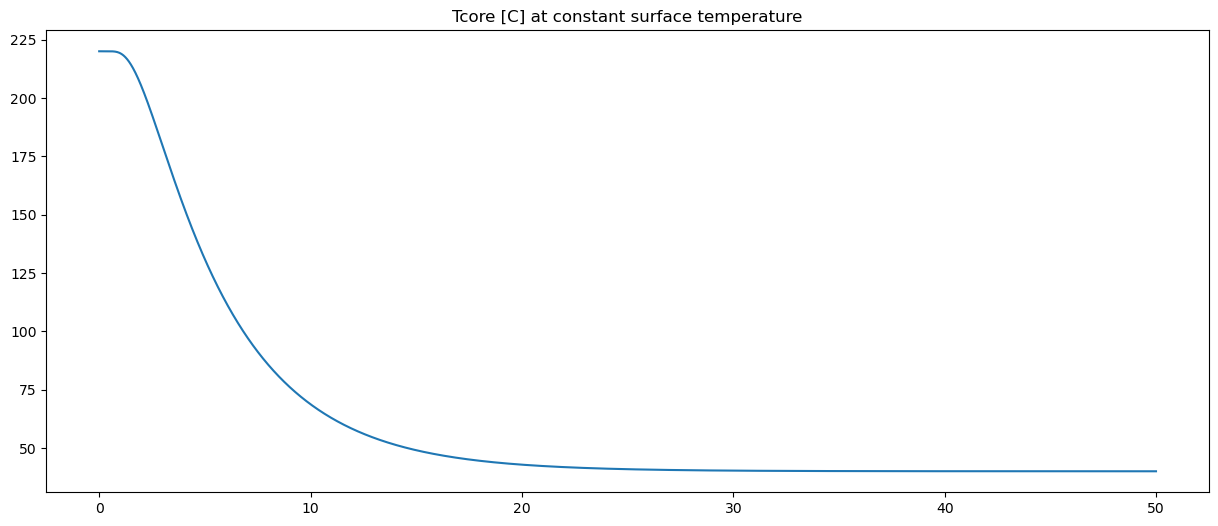

In [9]:
fig = plt.figure(figsize=(15,6))
heat = plt.plot(np.arange(0,t,dt), T_core)
plt.title('Tcore [C] at constant surface temperature')
plt.show()

#### Plot using 3D surface animation

In [33]:
from matplotlib import animation

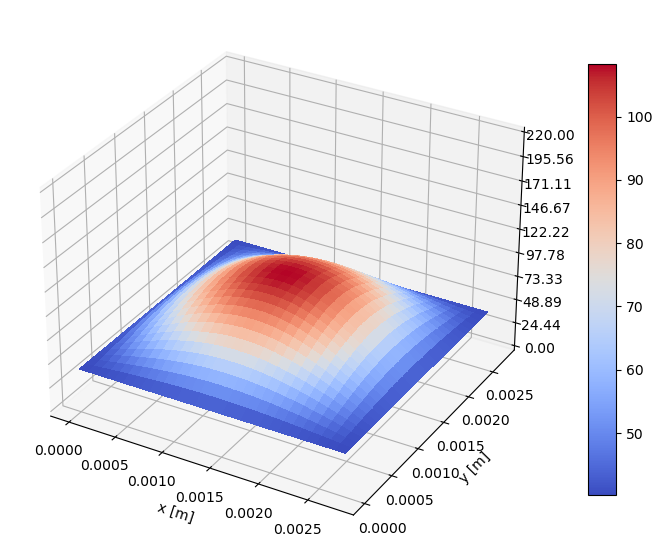

In [85]:
figmesh, ax = plt.subplots(figsize=(10,7),subplot_kw={'projection': '3d'})

xx,yy = np.meshgrid(x_vec, y_vec)

surf = ax.plot_surface(yy,xx,grid[500], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Label x and y axis
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

# Customize the z axis.
ax.set_zlim(0, 220)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
figmesh.colorbar(surf, shrink=0.8, aspect=15, ax=ax)


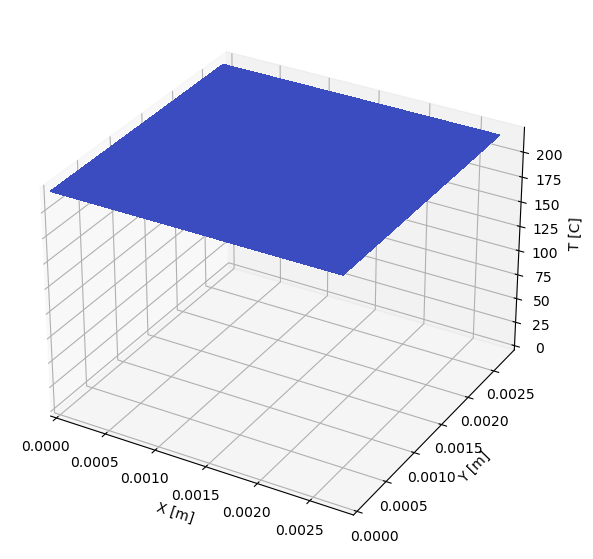

In [80]:
# Attaching 3D axis to the figure
figmesh, ax = plt.subplots(figsize=(10,7),subplot_kw={'projection': '3d'})
fps = 40
xx,yy = np.meshgrid(x_vec, y_vec)


def update_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(xx, yy, zarray[frame_number,:,:], cmap=cm.coolwarm, rstride=1, cstride=1, antialiased=False)

    return plot[0],
# surf = ax.plot_surface(yy,xx,grid[500], cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)

# Create lines initially without data
contour = [ax.plot_surface(xx, yy, grid[0,:,:], cmap=cm.coolwarm, rstride=1, cstride=1, antialiased=False)]

# Setting the axes properties
ax.set(xlim3d=(0, X), xlabel='X [m]')
ax.set(ylim3d=(0, Y), ylabel='Y [m]')
ax.set(zlim3d=(0, 220), zlabel='T [C]')

# Creating the Animation object
heat_ani = animation.FuncAnimation(figmesh, update_plot, len(grid), fargs=(grid, contour), interval=1)

plt.show()

##### Save animation as mp4 file

In [81]:
FFwriter = animation.FFMpegWriter(metadata={'title':'heat_animation'},fps=fps)
fn = 'heat_animation'
heat_ani.save(f'{fn}.mp4',writer=FFwriter)


### Cylindrical Coordinates - FDA 1D Heat Transfer

#### Define variables and time steps

In [ ]:
# Length (in x and y direction)
R = 0.00285 # m
# Size of length
N = 30
# Time
t = 50 # s
# Size of time
M = 4000
# Length steps and time steps
dr = R/N
r_vec_cyl = np.arange(0, R, dr)
dt = t/M
t_vec_cyl = np.arange(0, t, dt)
# k-value = thermal conductivity
k = 0.23 # W/mK
rho = 1230 # kg/m3
cp = 2100 # J/kgK
K = (k/(rho*cp)) * dt / dr**2
print(f'''
dr = {dr}
dt = {dt}
K = {K}
''')
 
# Check the stability based on Courant number for 1D heat equation
dt <= (dr**2/2)

#### Define grid (1D Heat Transfer in Cylindrical Coordinates)

In [ ]:
grid_cyl_surface = np.zeros(shape=(M,N))
grid_cyl_core = np.zeros(shape=(M,N))
print(f'''
Shape: {grid_cyl_surface.shape} 
Size: {grid_cyl_surface.size}
Dimension: {grid_cyl_surface.ndim}
''')
grid_cyl_surface

#### Fill grid

In [ ]:
# print(f'before: {grid_cyl[1]}')
# if i == 0, T is melt temperature
# if j == 0, T is surface temperature, if j == len(grid_cyl[i])-1, T is melt temperature

for i,time_plane in enumerate(grid_cyl_surface): # for each time step
    for j,y in enumerate(time_plane): # for each y step
        if i == 0:
            grid_cyl_surface[i] = 220 # fill first plane with initial temperatures of melt
            grid_cyl_core[i] = 220
        else:
            if j == 0: 
                grid_cyl_surface[i,j] = 220 # fill boundaries with temperature of cooling medium (assuming surface reaches Tboundary immediately after t=0)
                
            elif j == len(grid_cyl_surface[i])-1:
                grid_cyl_surface[i,j] = 40

            else:
                grid_cyl_surface[i,j] = grid_cyl_surface[i-1,j] + K * (grid_cyl_surface[i-1,j+1] - 2*grid_cyl_surface[i-1,j] + grid_cyl_surface[i-1,j-1])

# print(f'after: {grid_cyl[1]}')

In [ ]:
grid_cyl_surface

#### Plot matrix

In [ ]:
T_surface_cyl = [np.average(grid_cyl_surface[i,-2]) for i in range(len(grid_cyl_surface))]
T_core_cyl = [np.average(grid_cyl_surface[i,1]) for i in range(len(grid_cyl_surface))]
T_surface_cyl

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot(np.arange(0,t,dt), T_surface_cyl, label='T_surface')
plt.plot(np.arange(0,t,dt), T_core_cyl, label='T_core')
plt.title('Tsurface [C] at constant core temperature')
plt.legend()
plt.show()

In [ ]:
fig_surf, ax1 = plt.subplots(figsize=(10,5))

rr,tt = np.meshgrid(r_vec_cyl, t_vec_cyl)

surf = ax1.pcolormesh(tt,rr,grid_cyl_surface, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Label x and y axis
ax1.set_xlabel('time [s]')
ax1.set_ylabel('radius [m]')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.8, aspect=10, ax=ax1)


In [ ]:

surf = ax1.pcolormesh(tt,rr,grid_cyl_surface, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Label x and y axis
ax1.set_xlabel('time [s]')
ax1.set_ylabel('radius [m]')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.8, aspect=10, ax=ax1)
